## Lesson 11 Introduction to Spark

## Learning tasks
* Read through the online lesson notes and work through Jupyter Notebook version.
* Complete the non-graded exercises at the end of the lesson.
* Contribute to the discussion for the lesson. Discussion forum 11  will be closed by 11:59 p.m. Day 7 of Week 11. For further details consult the course syllabus.
* Work on Assignment 3 which is due at the end of Lesson 12. For further details consult the course syllabus.
* Work on your group Course project due at the end of the course.

## Lesson objectives

* Compare Hadoop and Spark, and explain the advantages and disadvantages of each.
* Explain the MapReduce algorithm.
* Write a simple Hadoop program.
* Write a simple Spark program.
* Explain the concept of the RDD (Resilient Distributed Dataset) in Spark.
* Use Spark map and filter functions to manipulate data in an RDD.
* Use RDD keys in Spark to perform reductions on data.

## Preliminaries

The format of this lesson will be a little bit different than in previous lessons.  This is because it has been generated using a Jupyter Notebook, an interface which lends itself particularly well to Python and Spark.  A Jupyter notebook allows one to mix executable cells containing source code, text and figures, which is extremely convenient.  A notebook file will be provided for you to download and run (ADD link once available), so you can run the commands shown here (unless otherwise noted).  In that sense you can treat the whole lesson as one giant exercise you can perform interactively.

With Hadoop and Spark the language of choice is typically a higher level language like Python.  There are many reasons for this.  For example, much of this kind of work involves manipulating strings, and Python has some very powerful tools easily available to manipulate strings.  If you need to get more comfortable with Python or Jupyter Notebooks, please spend some time to look at online tutorial resources for both before starting the next two lessons.

We are far enough along in this course for you to notice that parallel programming is rather hard.  Yet many companies routinely process gigantic amounts of data that certainly would be impossible without applying large amounts of parallel computing power.  Since few developers know low level parallel programming, tools had to be developed to, in a sense, "hide" the parallelism. Those tools provide a simple programming paradigm which the framework provided can parallelise automatically, as long as the program remains within the constraints of the framework. The two leading paradigms of this kind are Hadoop and its successor Spark.  The key algorithm emplyed by both is MapReduce.

## Hadooop and the MapReduce algorithm

In the early years of this millenium newly founded Google faced the need to process vast amount of data which they collected.  This data clearly required parallel computing and storage, but there were not enough developers who knew parallel programming to directly work with this data. To cope with this problem Google researchers implemented 
a new parallel computing frameword, described in a famous paper published in 2004 (http://static.googleusercontent.com/media/research.google.com/en//archive/mapreduce-osdi04.pdf MapReduce: Simplified Data Processing on Large Clusters).  The framework was called Hadoop and used the MapReduce algorith, with a parallel computing infrastructure that could implement it on large commodity clusters.

MapReduce as implemented in Hadoop is a method to process vast sums of data in parallel without requiring the developer to write any other code other than the mapper and reduce functions.  The functions can be developed and tested on a simple desktop or laptop, and then deployed without any changes to run on huge clusters with thousands of processors and terabytes of data.  No knowledge of low level parallel computing languages is required, as the Hadoop frameword hides all the details (eg. communications between processes) from the programmer.

The MapReduce algorithm is straightforward to write down, though understanding the details and implications of it may take some practice.  The programmer specifies a mapper function that processes key/value pair to generate set of intermediate key/value pairs, and a reducer function that merges all intermediate values associated with the same intermediate key.

More formally, the mapper function takes items from the input stream, and produces pairs (k1,v1), with k1 the key, and v1 evaluated by the mapper machine based on each key.  There are multiple mappers for large data sets and the Hadoop framework takes care of distributing the input stream data to the mappers.  The Hadoop framework then sorts the output of the mappers by key, and sends the results to reducer machine.  Each reducer then runs a reduction operation on its subset of (k1,v1) pairs.

Programs written in this functional style are automatically parallelized and executed on a large cluster of commodity machines.  The run-time system takes care of the details of partitioning input data, scheduling the program's execution across a set of machines, and managing inter-machine communication.
This allows programmers without any experience with parallel and distributed systems to easily utilize the resources of a large distributed system.

## Spark

Hadoop has to a large extent been replaced by Spark, being easier to use and more flexible, as you will see through the example below.  It is much more convenient to use, and does not require separate mapper and reducer scripts.  Even though it still uses a map reduce algorith, that is largely hidden from the programmer. Spark is also more efficient as it can hold whole datasets in memory instead of on disk as Hadoop does, increasing performance in many cases (as long as sets can fit in memory).

The quickest way to see the power of Spark is to show the same example of calculating Pi done in Spark.  The code is below.  The first 6 lines are just preliminaries to start a Spark instance, and are not even necessary when running in side a Jupyter notebook, as a Spark context object (sc) is already available by default.  

Next we define a function which generates random x,y in between 0 and 1, computes radius r, and returns True if that radius is less than False otherwise.

Then we employ a chain of spark operations.  First, 

sc.parallelize(range(0, num_samples))

creates a set object called a Resilient Distributed Dataset (RDD).  This step is equivalent to generating an input file for the Hadoop program above.

Next we apply a filter function to that set.  We could have done this in two lines:

tempcount=sc.parallelize(range(0, num_samples))
count=tempcount.filter(inside)

but Spark allows us to conveniently chain such operations together avoiding a temporary variable (which would use up memory space needlessly).  Thus, the above two lines can be replaced by:

count = sc.parallelize(range(0, num_samples)).filter(inside)

The filter operation(with the function inside as the argument) will produce a new RDD, by evaluating the function on all elements of the original RDD and keeping only those elements for which the function evaluates as True.  Finally, we apply the Spark count function to the RDD, which simply counts the number of elements in the RDD, which after filtering is exactly the number that we need to evaluate pi.

In [7]:
# You can run this code in the browser. Go ahead b pressing the Run button above, or shift-enter.

import pyspark
conf = pyspark.SparkConf().setAppName("AdelaideNotebook")
try:
   sc = pyspark.SparkContext(conf=conf)
except:
   print("Warning : a SparkContext already exists.")

import random
num_samples = 1000000000
def inside(p):     
  x, y = random.random(), random.random()
  return x*x + y*y < 1
count = sc.parallelize(range(0, num_samples)).filter(inside).count()
pi = 4 * count / num_samples
print(pi)

#sc.stop()

3.141562992


## Adelaide dataset

So far in this course we have mostly worked on numerical problems.  However, a great deal of parallel computing involves analysing large amounts of text data.  This is what Spark is particularly suited for. 

Below is a data scraping program which obtains the information from the website.  We collect the full data containing the contents of the books, as well as a much smaller data set containing only the metadata.

The total data the program scrapes is 1.7 Gb.

The Python program below uses multithreaded parallelism, implemented through the concurrent features of Python 3.  However, this is not true parallelism because of Global Interpreter Lock which prevents Python from having multiple active threads computing at the same time.  Multiple threads may exist at the same time, but only one of them is actually making progress at any given time.

After our scraping program has collected this data, we load it into spark as an RDD.  Operations on the full dataset, with titles running from A to Z can be somewhat time consuming, so for convenience we have a variable which holds the range of letters for which files will be loaded.  Thus, if you want to only look for titles beginning with A and B, you would define it to be [A-B].

In [18]:
#Run the code in this box, and then continue running the boxes (in order) until the end of lesson.
import pyspark
conf = pyspark.SparkConf().setAppName("AdelaideNotebook")

try:
    sc = pyspark.SparkContext(conf=conf)
except:
    print("Warning : a SparkContext already exists.")

letter_range="[A-Z]" # specify alphabetical range of titles we will process. This variable will be used later 
# if you want your dataset to be smaller, so that calculations go faster, reduce the range
adelaide_meta_json = sc.textFile("./data/*meta*"+letter_range+"*.json")

The adelaide_meta_json object is an RDD.  While the RDD appears deceptively simple to the programmer, it is actually a complex object, which on a parallel computer would have its data distributed on multiple machines and disks.  The precise arrangement of the data is taken care of by the Spark framework without attention from the programmer.

After reading in the data set, we would like to quickly see what it contains.  The object storing the data is an RDD, as we can verify by running the type command on it.  This object can be quite large and its storage may be distributed if we are not using a single machine. If we tried to print all the entries with rdd.foreach(println) or rdd.map(println), that might work in local mode on a single machine, but on a cluster each executor will have its own stdout and send its output there, so we would not see it.

If we tried to collect the whole dataset, it might not fit on the node we are using.

This is why the RDD has the take method, which can be used to extract a list of first N elements from the RDD and make it available on the head node.  The result of this operation is not an RDD but just a normal list.

There are some operations which are always useful.  The count method returns the number of items in the RDD which gives a useful indication of its size.  The take method will produce a list, as we can see by quering its type.  We can also print the whole list.

In [19]:
print(adelaide_meta_json.count())
meta_first2 = adelaide_meta_json.take(2)
print(type(adelaide_meta_json))
print(type(meta_first2))
print(meta_first2)

4458
<class 'pyspark.rdd.RDD'>
<class 'list'>
['{"publisher": "The University of Adelaide Library", "image": "https://ebooks.adelaide.edu.au/d/doyle/arthur_conan/american-s-tale/cover.jpg", "url": "https://ebooks.adelaide.edu.au/d/doyle/arthur_conan/american-s-tale/", "name": "The American\\u2019s Tale", "description": "The American\\u2019s Tale : an Arizona tragedy / Arthur Conan Doyle", "@context": "http://schema.org", "keywords": "Literature", "author": "Doyle, Arthur Conan, Sir, 1859-1930.", "@type": "Book", "inLanguage": "en"}', '{"@type": "Book", "@context": "http://schema.org", "url": "https://ebooks.adelaide.edu.au/o/oppenheim/e_phillips/amazing-partnership/", "dateCreated": "1914", "datePublished": "2016-02-01", "author": "Oppenheim, E. Phillips (Edward Phillips), 1866-1946", "image": "https://ebooks.adelaide.edu.au/o/oppenheim/e_phillips/amazing-partnership/cover.jpg", "name": "The Amazing Partnership", "keywords": "Literature", "publisher": "The University of Adelaide Librar

It is also possible to loop through a list produced by the take() method if that is more convenient.

In [20]:
for entry in meta_first2:
    print(entry)
    print(type(entry))

{"publisher": "The University of Adelaide Library", "image": "https://ebooks.adelaide.edu.au/d/doyle/arthur_conan/american-s-tale/cover.jpg", "url": "https://ebooks.adelaide.edu.au/d/doyle/arthur_conan/american-s-tale/", "name": "The American\u2019s Tale", "description": "The American\u2019s Tale : an Arizona tragedy / Arthur Conan Doyle", "@context": "http://schema.org", "keywords": "Literature", "author": "Doyle, Arthur Conan, Sir, 1859-1930.", "@type": "Book", "inLanguage": "en"}
<class 'str'>
{"@type": "Book", "@context": "http://schema.org", "url": "https://ebooks.adelaide.edu.au/o/oppenheim/e_phillips/amazing-partnership/", "dateCreated": "1914", "datePublished": "2016-02-01", "author": "Oppenheim, E. Phillips (Edward Phillips), 1866-1946", "image": "https://ebooks.adelaide.edu.au/o/oppenheim/e_phillips/amazing-partnership/cover.jpg", "name": "The Amazing Partnership", "keywords": "Literature", "publisher": "The University of Adelaide Library", "description": "The Amazing Partner

Finally, it is often sufficient to just examine the first elements of the RDD, since all the other elements must be of the same kind.  For this we can use the first() method of the RDD.  We can see that the RDD elements in adelaide_meta_json are just simple strings, but those strings contain code which Python can interpret as a dictionary.  To convert the string to a dictionary, we employ the json.loads method from the json module.  We apply it to the first element of the RDD and verify that it works.

In [21]:
import json
meta_first=adelaide_meta_json.first()
print(meta_first)
print(type(meta_first))
meta_first_dictionary=json.loads(meta_first)
print(type(meta_first_dictionary))
print(meta_first_dictionary["author"])

{"publisher": "The University of Adelaide Library", "image": "https://ebooks.adelaide.edu.au/d/doyle/arthur_conan/american-s-tale/cover.jpg", "url": "https://ebooks.adelaide.edu.au/d/doyle/arthur_conan/american-s-tale/", "name": "The American\u2019s Tale", "description": "The American\u2019s Tale : an Arizona tragedy / Arthur Conan Doyle", "@context": "http://schema.org", "keywords": "Literature", "author": "Doyle, Arthur Conan, Sir, 1859-1930.", "@type": "Book", "inLanguage": "en"}
<class 'str'>
<class 'dict'>
Doyle, Arthur Conan, Sir, 1859-1930.


Now that we have verified our transformation works on a single entry, we can now apply it to the whole RDD, generating a new RDD.  To do this, we apply the map() method of the RDD the the json.loads function as an argument.  This will generate a new RDD by applying json.loads to every element of the old RDD.

In [22]:
adelaide_meta = adelaide_meta_json.map(json.loads)

We now verify the map has worked correctly by looking at the first element of the new RDD.

In [25]:
print(type(adelaide_meta))
print(adelaide_meta.first())
print(type(adelaide_meta.first()))
meta_first=adelaide_meta.first()
print(meta_first["author"])

<class 'pyspark.rdd.PipelinedRDD'>
{'publisher': 'The University of Adelaide Library', 'image': 'https://ebooks.adelaide.edu.au/d/doyle/arthur_conan/american-s-tale/cover.jpg', 'url': 'https://ebooks.adelaide.edu.au/d/doyle/arthur_conan/american-s-tale/', 'name': 'The American’s Tale', 'description': 'The American’s Tale : an Arizona tragedy / Arthur Conan Doyle', '@context': 'http://schema.org', 'keywords': 'Literature', 'author': 'Doyle, Arthur Conan, Sir, 1859-1930.', '@type': 'Book', 'inLanguage': 'en'}
<class 'dict'>
Doyle, Arthur Conan, Sir, 1859-1930.


We can see that the files have been added to the RDD in no systematic order. There is no guarantee that books will be present in alphabetical order, for example.

There are numbers methods associated with an RDD object, and we have seen only a few so far.  To see all of the methods listed for an RDD object (and for any Python object in general) we can call the help function with the object name as an argument, which will list all the methods.

The output of this function can be quite large, so here we use the capture magic of Jupyter notebook (%% capture c).
This permits us to redirect output of a cell to a special object.

In [28]:
%%capture c
help(adelaide_meta_json)

Because we have used (%%capture), the output of the cell above has not been shown, but is saved instead.  Now we have more control over what portion of the output we show.  The code below shows only 20 lines of the output.  If you don't care about the length of the output, you can just run help(adelaide_meta_json) without any notebook magic and you can just see the output directly.

In [26]:
# we could display specific parts of help output!
d=str(c).split("\n")
print(*d[0:20],sep="\n")

Help on RDD in module pyspark.rdd object:

class RDD(typing.Generic)
 |  RDD(jrdd: 'JavaObject', ctx: 'SparkContext', jrdd_deserializer: pyspark.serializers.Serializer = AutoBatchedSerializer(CloudPickleSerializer()))
 |
 |  A Resilient Distributed Dataset (RDD), the basic abstraction in Spark.
 |  Represents an immutable, partitioned collection of elements that can be
 |  operated on in parallel.
 |
 |  Method resolution order:
 |      RDD
 |      typing.Generic
 |      builtins.object
 |
 |  Methods defined here:
 |
 |  __add__(self: 'RDD[T]', other: 'RDD[U]') -> 'RDD[Union[T, U]]'
 |      Return the union of this RDD and another one.
 |
 |      Examples


## Filtering a Dataset

As we obtained our data from scraping the internet, it is quite likely that it contains some bad or incomplete entries, for example:

{"description": "ERROR_COMP_NOT_FOUND"}

Let's now restrict our dataset to only keep entries for which the fields ''author'' and ''name'' are in the dictionary. To do so, we first define a function that returns True if those fields are present. 

In [29]:
def is_author_title_defined(record):
    return "author" and "name" in record

We now use this function as a filter, generating a new RDD consisting of the values of the original RDD for which the function in the filter returns True.

In [30]:
adelaide_meta_filt = adelaide_meta.filter(is_author_title_defined)

We can now compare the lengths of the original and new RDDs to see how many bad values have been filtered out.  Note that Spark uses lazy evaluation, so the actual computation and creation of new dataset is not actually carried out until its values are used.  So the line above might have evaluated in a fraction of a second, because no actual work has been done.  The RDD would actually be constructed in cell below, where its elements are actually accessed.  We can see that the new set has fewer elements than the original set, so some bad entries have indeed been present and are now filtered out.  First we also print the first elements of the original and new RDD just to see that they look reasonable.  This is a good habit to get into any time you generate a new dataset from an existing one.

In [31]:
print(adelaide_meta.first())
print(adelaide_meta_filt.first())
meta_count = adelaide_meta.count()
print(meta_count)
meta_count_filt = adelaide_meta_filt.count()
print(meta_count_filt)

{'publisher': 'The University of Adelaide Library', 'image': 'https://ebooks.adelaide.edu.au/d/doyle/arthur_conan/american-s-tale/cover.jpg', 'url': 'https://ebooks.adelaide.edu.au/d/doyle/arthur_conan/american-s-tale/', 'name': 'The American’s Tale', 'description': 'The American’s Tale : an Arizona tragedy / Arthur Conan Doyle', '@context': 'http://schema.org', 'keywords': 'Literature', 'author': 'Doyle, Arthur Conan, Sir, 1859-1930.', '@type': 'Book', 'inLanguage': 'en'}
{'publisher': 'The University of Adelaide Library', 'image': 'https://ebooks.adelaide.edu.au/d/doyle/arthur_conan/american-s-tale/cover.jpg', 'url': 'https://ebooks.adelaide.edu.au/d/doyle/arthur_conan/american-s-tale/', 'name': 'The American’s Tale', 'description': 'The American’s Tale : an Arizona tragedy / Arthur Conan Doyle', '@context': 'http://schema.org', 'keywords': 'Literature', 'author': 'Doyle, Arthur Conan, Sir, 1859-1930.', '@type': 'Book', 'inLanguage': 'en'}
4458
4389


## Filtering Duplicate Entries

It is possible that the same book is listed multiple times.  Here we will consider two books to be the same if they have the same URL listed. To see this, let's make an RDD consisting only of the URL value of each entry.  We now use a filter made out of a lambda function, which returns the 'url' field in the dictionary.

In [32]:
meta_urls = adelaide_meta_filt.map(lambda rec: rec['url'])

We can now use the distict method of the RDD to eliminate multiple entries.

In [33]:
meta_urls.count() - meta_urls.distinct().count()

305

There are 305 duplicated entries in the dataset.  To eliminate them, we create a new RDD which consists of the old RDD data plus a key, the key in this case being the url. To do that, we use the keyBy method of the RDD. 

In [34]:
adelaide_meta_url_key = adelaide_meta_filt.keyBy(lambda rec: rec['url'])

We can look at the result.  This creates a specific kind of RDD, a pair (key,value) RDD.

In [35]:
adelaide_meta_url_key.first()

('https://ebooks.adelaide.edu.au/d/doyle/arthur_conan/american-s-tale/',
 {'publisher': 'The University of Adelaide Library',
  'image': 'https://ebooks.adelaide.edu.au/d/doyle/arthur_conan/american-s-tale/cover.jpg',
  'url': 'https://ebooks.adelaide.edu.au/d/doyle/arthur_conan/american-s-tale/',
  'name': 'The American’s Tale',
  'description': 'The American’s Tale : an Arizona tragedy / Arthur Conan Doyle',
  '@context': 'http://schema.org',
  'keywords': 'Literature',
  'author': 'Doyle, Arthur Conan, Sir, 1859-1930.',
  '@type': 'Book',
  'inLanguage': 'en'})

There are special methods to access the first element (keys()) and the second element(values()).

In [36]:
print(adelaide_meta_url_key.keys().first())
print("-----------------------")
print(adelaide_meta_url_key.values().first())

https://ebooks.adelaide.edu.au/d/doyle/arthur_conan/american-s-tale/
-----------------------
{'publisher': 'The University of Adelaide Library', 'image': 'https://ebooks.adelaide.edu.au/d/doyle/arthur_conan/american-s-tale/cover.jpg', 'url': 'https://ebooks.adelaide.edu.au/d/doyle/arthur_conan/american-s-tale/', 'name': 'The American’s Tale', 'description': 'The American’s Tale : an Arizona tragedy / Arthur Conan Doyle', '@context': 'http://schema.org', 'keywords': 'Literature', 'author': 'Doyle, Arthur Conan, Sir, 1859-1930.', '@type': 'Book', 'inLanguage': 'en'}


The final step is to transform the RDD to generated a new one where we keep only one value for each entry that shares the same key.  To do this we apply a reduction operation, where for two records a and b with the same key, we only return the first record a.

In [37]:
adelaide_meta_unique = adelaide_meta_url_key.reduceByKey(lambda a, b: a)

We now count the elements in the resulting dataset.  We can see again that the count has decreased, so there were duplicate entries that are now eliminated.

In [38]:
adelaide_meta_unique.count()

4084

## Caching

When we expect to operate frequently on the same dataset, it might be useful to tell Spark to keep it in memory.  For that, we can use the cache() method.  If you plan to do a large operation on an RDD, apply the cache() method to it first.

## Processing

At the end of the last stage we have a list of unique data, but it is in the form of a tuple of two elements.  To get rid of the first element and go back to a set consisting of Python dictionaries, we apply a map which takes a tuple and returns only the second element of it.

In [39]:
adelaide_meta=adelaide_meta_unique.map(lambda a:a[1])
print("type of adelaide_meta is",type(adelaide_meta.first()))
print("first element of adelaide_meta is \n",adelaide_meta.first())
print("number of elements in adelaide_meta after eliminating duplicates is now ", adelaide_meta.count())

type of adelaide_meta is <class 'dict'>
first element of adelaide_meta is 
 {'publisher': 'The University of Adelaide Library', '@type': 'Book', '@context': 'http://schema.org', 'url': 'https://ebooks.adelaide.edu.au/l/lefanu/aungier/', 'dateCreated': '1851', 'datePublished': '2010-03-27', 'author': 'Le Fanu, Joseph Sheridan, 1814-1873.', 'name': 'An Account of Some Strange Disturbances in Aungier Street', 'dateModified': '2014-02-25', 'keywords': 'Literature', 'image': 'https://ebooks.adelaide.edu.au/l/lefanu/aungier/cover.jpg', 'description': 'An Account of Some Strange Disturbances in Aungier Street / J. Sheridan Le Fanu', 'inLanguage': 'en'}
number of elements in adelaide_meta after eliminating duplicates is now  4084


Each entry in the RDD is a dictionary, and each dictionary may contain a variable number of keys, with the keys not necessarily shared between different dictionaries.  We can extract the keys from each dictionary, using the method keys().

In [40]:
adelaide_meta.first().keys()

dict_keys(['publisher', '@type', '@context', 'url', 'dateCreated', 'datePublished', 'author', 'name', 'dateModified', 'keywords', 'image', 'description', 'inLanguage'])

We would like to apply this method to every dictionary in our dataset through a map.  But for a simple map, we would get an RDD of key lists.  What we actually want is the merge of all these lists, so we can see all the  different keys we have across the various dictionaries.  This merge can be accomplished by the flatMap() method of the RDD.

In [41]:
adelaide_keys = adelaide_meta.flatMap(lambda rec: rec.keys())

In [42]:
adelaide_keys.take(5)

['publisher', '@type', '@context', 'url', 'dateCreated']

We want the frequency of each key.

In [43]:
adelaide_key_value = adelaide_keys.map(lambda key: (key, 1))
adelaide_key_value.first()

('publisher', 1)

This can be accomplished by a reduction by key using the add operator.

In [44]:
from operator import add

adelaide_agg = adelaide_key_value.reduceByKey(add)

In [45]:
adelaide_agg.take(5)

[('inLanguage', 4084),
 ('illustrator', 19),
 ('type', 1),
 ('alternateName', 8),
 ('@context', 4084)]

In [46]:
adelaide_agg.count()

31

The total number of keys is small so we can collect it into a dictionary, using the collectAsMap method of an RDD.

In [47]:
type(adelaide_agg.collectAsMap())

dict

In [48]:
adelaide_agg.collectAsMap()

{'inLanguage': 4084,
 'illustrator': 19,
 'type': 1,
 'alternateName': 8,
 '@context': 4084,
 'editor': 3,
 'datePublished': 2534,
 'authors': 7,
 'subjects': 131,
 'publisher': 4084,
 'language': 1,
 'dateCreated': 1737,
 'translators': 1,
 'cover': 4,
 'author': 4061,
 'format': 1,
 'name': 4084,
 'contents': 8,
 '@type': 4084,
 'genre': 3,
 'image': 4076,
 'contributors': 459,
 'url': 4084,
 'dateModified': 2785,
 'description': 4084,
 'source': 541,
 'translator': 189,
 'contributor': 6,
 'license': 1,
 'keywords': 3432,
 'collections': 19}

We can now observe that only a few keys are available in most of the dictionaries of our data set.  We should concentrate our analysis on those.

## Transforming the dataset

Let's say we want to do some analysis on the ages of the authors.  In our dataset, most of the dictionaries contain the author field, which usually has the name of the author, the year of birth and the year of death.  We want to transform the dataset so that birth and death years are parts of it directly.

In [50]:
import re
def process_name_birth_death(record):
    author = record.get('author', None)
    if author:
        author = author.strip()
        # Remove trailing dot
        if '.' == author[-1]:
            author = author[:-1]
        try:
            lastname, firstname, birth_death = author.split(',')
        except ValueError:
            return record
        try:
            birth, death = re.findall('\d+', birth_death)
        except ValueError:
            return record
        record['author_lastname'] = lastname.strip()
        record['author_firstname'] = firstname.strip()
        record['author_birth'] = int(birth)
        record['author_death'] = int(death)
    return record

<>:14: SyntaxWarning: invalid escape sequence '\d'
<>:14: SyntaxWarning: invalid escape sequence '\d'
/var/folders/bj/spr6xdy950jf8sj2svjhs0vh0000gn/T/ipykernel_8561/3494965734.py:14: SyntaxWarning: invalid escape sequence '\d'
  birth, death = re.findall('\d+', birth_death)


We first run this function on a single dictionary to make sure it works correctly.

In [51]:
test=adelaide_meta.first()
process_name_birth_death(test)

{'publisher': 'The University of Adelaide Library',
 '@type': 'Book',
 '@context': 'http://schema.org',
 'url': 'https://ebooks.adelaide.edu.au/l/lefanu/aungier/',
 'dateCreated': '1851',
 'datePublished': '2010-03-27',
 'author': 'Le Fanu, Joseph Sheridan, 1814-1873.',
 'name': 'An Account of Some Strange Disturbances in Aungier Street',
 'dateModified': '2014-02-25',
 'keywords': 'Literature',
 'image': 'https://ebooks.adelaide.edu.au/l/lefanu/aungier/cover.jpg',
 'description': 'An Account of Some Strange Disturbances in Aungier Street / J. Sheridan Le Fanu',
 'inLanguage': 'en',
 'author_lastname': 'Le Fanu',
 'author_firstname': 'Joseph Sheridan',
 'author_birth': 1814,
 'author_death': 1873}

Once it is verified to work, we apply it to the whole RDD through a map.

In [52]:
adelaide_meta_val = adelaide_meta.map(process_name_birth_death)


We verify we did this correctly by looking the the first two elements of the resulting RDD.

In [53]:
adelaide_meta_val.take(2)

[{'publisher': 'The University of Adelaide Library',
  '@type': 'Book',
  '@context': 'http://schema.org',
  'url': 'https://ebooks.adelaide.edu.au/l/lefanu/aungier/',
  'dateCreated': '1851',
  'datePublished': '2010-03-27',
  'author': 'Le Fanu, Joseph Sheridan, 1814-1873.',
  'name': 'An Account of Some Strange Disturbances in Aungier Street',
  'dateModified': '2014-02-25',
  'keywords': 'Literature',
  'image': 'https://ebooks.adelaide.edu.au/l/lefanu/aungier/cover.jpg',
  'description': 'An Account of Some Strange Disturbances in Aungier Street / J. Sheridan Le Fanu',
  'inLanguage': 'en',
  'author_lastname': 'Le Fanu',
  'author_firstname': 'Joseph Sheridan',
  'author_birth': 1814,
  'author_death': 1873},
 {'publisher': 'The University of Adelaide Library',
  'image': 'https://ebooks.adelaide.edu.au/b/benson/ef/and-the-dead-spake/cover.jpg',
  'url': 'https://ebooks.adelaide.edu.au/b/benson/ef/and-the-dead-spake/',
  'name': 'And the Dead Spake',
  'description': 'And the Dea

We could also apply a transformation to change works created before year 0 CE to have a negative value, which might help in our analysis.  The function to do this is below:

In [54]:
def convert_dateCreated(record):
    if 'dateCreated' in record:
        dates = re.findall('\d+', record['dateCreated'])
        if len(dates) > 0:
            date = int(dates[0])
            # Check if the date is before common era
            if re.match(r'BC|bc|BCE|bce', record['dateCreated']):
                date *= -1
            record['dateCreated'] = date
        else:
            del record['dateCreated']
    return record

<>:3: SyntaxWarning: invalid escape sequence '\d'
<>:3: SyntaxWarning: invalid escape sequence '\d'
/var/folders/bj/spr6xdy950jf8sj2svjhs0vh0000gn/T/ipykernel_8561/3654922853.py:3: SyntaxWarning: invalid escape sequence '\d'
  dates = re.findall('\d+', record['dateCreated'])


We apply the function through a map.  In this case the new RDD overwrites the old RDD.

In [55]:
adelaide_meta_val = adelaide_meta_val.map(convert_dateCreated)


## First analysis: authors' life expectancy

Now that we have the metadata RDD filtered to our satisfaction, we can do some analysis on the data it contains.  To do this, we write a function that computes the age (at death) of the author.  It is not a perfect function in that it will get confused if an author's lifetime spanned year 0, but it's good enough for our purposes.  After the function is defined and applied through map() to the RDD, we then apply the count by countByValue method, which will count how many times each value is present and produce a list holding this information.  The resulting list is not an RDD, so we can work with it like with other standard Python objects.

In [56]:
def compute_age(rec):
    """Compute the age of an author when it died
    based on its year of birth and death.
    """
    if 'author_birth' and 'author_death' in rec:
        birth, death =  rec['author_birth'], rec['author_death']
        if birth < death:
            return death - birth
        else:
            # If year of birth is greater than year of death the
            # author was born in BCE. This will not be correct for authors 
            # who were alive 1 CE, crossing over the BCE and CE boundary,
            # but we will not worry about this artifact in this exercise.
            return birth - death
    else:
        return None

age_frequency = adelaide_meta_val.map(compute_age).countByValue()

print(age_frequency)

defaultdict(<class 'int'>, {59: 91, 73: 222, 78: 77, 83: 35, 58: 97, 48: 21, 49: 11, 47: 106, 84: 26, 76: 22, 74: 70, None: 478, 51: 86, 43: 318, 67: 130, 88: 38, 57: 25, 62: 85, 65: 170, 61: 59, 90: 10, 69: 48, 46: 97, 44: 96, 56: 54, 77: 88, 45: 58, 80: 146, 50: 11, 82: 111, 81: 75, 70: 58, 41: 13, 60: 48, 85: 15, 33: 7, 55: 84, 68: 97, 52: 97, 72: 48, 40: 61, 75: 85, 66: 108, 71: 86, 39: 12, 32: 2, 64: 39, 38: 50, 93: 8, 94: 11, 29: 11, 87: 5, 54: 20, 89: 22, 37: 12, 79: 37, 92: 2, 86: 7, 30: 9, 36: 7, 26: 13, 27: 1, 42: 9, 63: 16, 34: 10, 53: 3, 101: 1, 35: 7, 91: 1, 31: 1})


To understand this data we use the standard Python plotting library matplotlib.  Again, as with BeautifulSoup, mastering this library is outside the scope of this course.  Here we are using it as an utility.  If you want to understand it in more detail, refer to the tutorials available online.

[59, 73, 78, 83, 58, 48, 49, 47, 84, 76, 74, None, 51, 43, 67, 88, 57, 62, 65, 61, 90, 69, 46, 44, 56, 77, 45, 80, 50, 82, 81, 70, 41, 60, 85, 33, 55, 68, 52, 72, 40, 75, 66, 71, 39, 32, 64, 38, 93, 94, 29, 87, 54, 89, 37, 79, 92, 86, 30, 36, 26, 27, 42, 63, 34, 53, 101, 35, 91, 31]
[91, 222, 77, 35, 97, 21, 11, 106, 26, 22, 70, 478, 86, 318, 130, 38, 25, 85, 170, 59, 10, 48, 97, 96, 54, 88, 58, 146, 11, 111, 75, 58, 13, 48, 15, 7, 84, 97, 97, 48, 61, 85, 108, 86, 12, 2, 39, 50, 8, 11, 11, 5, 20, 22, 12, 37, 2, 7, 9, 7, 13, 1, 9, 16, 10, 3, 1, 7, 1, 1]
[73 78 83 58 48 49 47 84 76 74 None 51 43 67 88 57 62 65 61 90 69 46 44 56
 77 45 80 50 82 81 70 41 60 85 33 55 68 52 72 40 75 66 71 39 32 64 38 93
 94 29 87 54 89 37 79 92 86 30 36 26 27 42 63 34 53 101 35 91 31]
[222  77  35  97  21  11 106  26  22  70 478  86 318 130  38  25  85 170
  59  10  48  97  96  54  88  58 146  11 111  75  58  13  48  15   7  84
  97  97  48  61  85 108  86  12   2  39  50   8  11  11   5  20  22  12
  37   2

/var/folders/bj/spr6xdy950jf8sj2svjhs0vh0000gn/T/ipykernel_8561/3192641303.py:17: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string ".b-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(x,y,'.b-',linestyle='None')


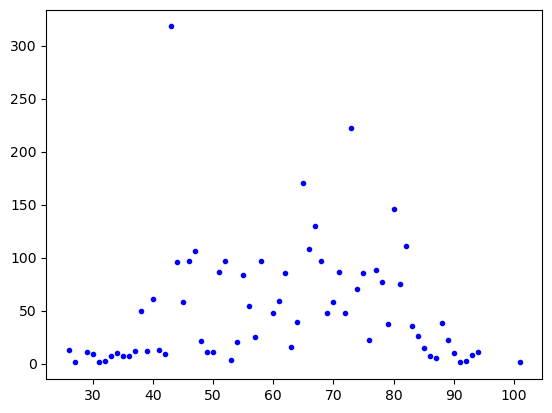

In [58]:
# need to add plot
import matplotlib
import matplotlib.pyplot as plt
import numpy

age=list(age_frequency.keys())
frequency=list(age_frequency.values())
print(age)
print(frequency)
x=numpy.array(age[1:]) # not taking the "None" key by starting at position 1
y=numpy.array(frequency[1:]) # not taking the "None" frequency by starting at position 1
print(x)
print(y)
#fig,ax=plt.subplots()
#ax.plot(x,y)
#plt.scatter(x,y)
plt.plot(x,y,'.b-',linestyle='None')
plt.show()
#run this box again if figure does not appear

(graphic generated by me in this notebook)

Our data has a strange spike at 43. Could we be doing something wrong?  Yes, we are considering multiple books by the same author separately.   Therefore, if there is one particular author that happens to be the author of a large number of books in this database, our results will be skewed.  To fix this, lets make a new RDD that consists of tuples with three elements each for an author: first name, last name, age.

In [59]:
def retrieve_name_age(rec):
    age = compute_age(rec)
    lastname = rec['author_lastname']
    firstname = rec['author_firstname']
    return firstname, lastname, age

authors = adelaide_meta_val.filter(lambda rec: 'author_lastname' in rec).map(retrieve_name_age)
authors.take(5)

[('Joseph Sheridan', 'Le Fanu', 59),
 ('E. F. (Edward Frederic)', 'Benson', 73),
 ('Jonathan', 'Swift', 78),
 ('Augustine', 'Birrell', 83),
 ('Nellie', 'Bly', 58)]

We can now apply the distinct() method to this RDD to eliminate indentical elements.  In the resulting dataset, each author is listed only once.

In [60]:
unique_authors = authors.distinct()
print(authors.count(),unique_authors.count())

3606 583


We can see that there are only 583 unique authors for our 3606 books.  We make the RDD containing only the age, and apply countByValue() method to get data for a new histogram.

In [61]:
age_frequency2 = unique_authors.map(lambda tup: tup[2]).countByValue()

We then plot it again with matplotlib.

[84, 74, 45, 80, 66, 29, 92, 30, 55, 83, 59, 78, 62, 46, 82, 54, 63, 58, 72, 75, 79, 68, 88, 71, 85, 73, 57, 51, 38, 47, 31, 61, 77, 56, 41, 34, 69, 50, 33, 26, 90, 35, 53, 81, 39, 37, 42, 101, 70, 65, 67, 64, 52, 43, 76, 48, 91, 27, 60, 32, 87, 44, 93, 36, 49, 89, 86, 40, 94]
[4, 12, 6, 21, 17, 4, 2, 3, 9, 13, 16, 12, 12, 13, 15, 9, 14, 16, 15, 21, 10, 19, 8, 15, 11, 13, 17, 9, 6, 11, 1, 15, 11, 10, 4, 4, 17, 6, 5, 3, 5, 4, 3, 10, 6, 6, 3, 1, 13, 18, 10, 10, 6, 5, 6, 10, 1, 1, 5, 1, 4, 6, 1, 1, 4, 5, 3, 5, 1]
[ 74  45  80  66  29  92  30  55  83  59  78  62  46  82  54  63  58  72
  75  79  68  88  71  85  73  57  51  38  47  31  61  77  56  41  34  69
  50  33  26  90  35  53  81  39  37  42 101  70  65  67  64  52  43  76
  48  91  27  60  32  87  44  93  36  49  89  86  40  94]
[12  6 21 17  4  2  3  9 13 16 12 12 13 15  9 14 16 15 21 10 19  8 15 11
 13 17  9  6 11  1 15 11 10  4  4 17  6  5  3  5  4  3 10  6  6  3  1 13
 18 10 10  6  5  6 10  1  1  5  1  4  6  1  1  4  5  3  5  1]

/var/folders/bj/spr6xdy950jf8sj2svjhs0vh0000gn/T/ipykernel_8561/233018324.py:17: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string ".b-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(x,y,'.b-',linestyle='None')


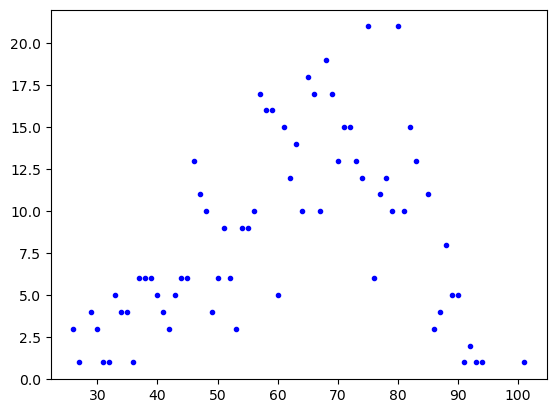

In [62]:
# need to add plot
import matplotlib
import matplotlib.pyplot as plt
import numpy

age=list(age_frequency2.keys())
frequency=list(age_frequency2.values())
print(age)
print(frequency)
x=numpy.array(age[1:]) # not taking the "None" key by starting at position 1
y=numpy.array(frequency[1:]) # not taking the "None" frequency by starting at position 1
print(x)
print(y)
#fig,ax=plt.subplots()
#ax.plot(x,y)
#plt.scatter(x,y)
plt.plot(x,y,'.b-',linestyle='None')
plt.show()

(figure generated by me)
Notice that the peak has disappeared.  Probably there were some authors aged 43 who happened to have a large number of books in our collection.  Not counting those books multiple times elimited the artifact. Now the data looks more regular and follows a clear trend.

## Working with full text

We now read in the .json files with full text that we have created by scraping the web previously.

In [63]:
# letter_range was defined above when reading meta files
adelaide_page_json = sc.textFile("./data/*page*"+letter_range+"*.json")
print(adelaide_page_json.count())


4458


There are 4458 elements in this RDD.

In [66]:
type(adelaide_page_json.first()) # at this point RDD consists of strings

str

At this point the RDD consists of strings.  Let's examine the first string. It happens to be a string with a link followed by "None", indicating that in this particular case the data for the book was not successfully retrieved during the web scraping operation.   Other entries will contain the link followed by the full HTML page code for that particular book.  We want to filter out the "None" entries but for that we will have to convert the data from a simple string into something more useful.

In [65]:
print(adelaide_page_json.first())

["https://ebooks.adelaide.edu.au/m/maupassant/guy/accursed-bread/", "<!DOCTYPE html>\n\n<html xmlns=\"http://www.w3.org/1999/xhtml\">\n<head>\n<meta charset=\"utf-8\"/>\n<title>The Accursed Bread / Guy de Maupassant</title><script type=\"application/ld+json\">\n{\n   \"@context\" : \"http://schema.org\",\n   \"@type\" : \"Book\",\n   \"author\" : \"Maupassant, Guy de, 1850-1893\",\n   \"image\" : \"https://ebooks.adelaide.edu.au/m/maupassant/guy/accursed-bread/cover.jpg\",\n   \"dateCreated\" : \"1883\",\n   \"datePublished\" : \"2016-01-26\",\n   \"description\" : \"The Accursed Bread : (Le Pain Maudit) / Guy de Maupassant\",\n   \"inLanguage\" : \"en\",\n   \"name\" : \"The Accursed Bread\",\n   \"publisher\" : \"The University of Adelaide Library\",\n   \"keywords\" : \"Literature\",\n   \"url\" : \"https://ebooks.adelaide.edu.au/m/maupassant/guy/accursed-bread/\"\n}\n</script>\n<!-- open graph -->\n<meta content=\"The Accursed Bread\" property=\"og:title\"/>\n<meta content=\"The Ac

We must now convert these strings into Python objects that we can manipulate further. We can use the json module for this.

The entry consists of a list with two elements: the url of a page followed by the HTML content of the page.  We should get rid of entries containing "None".

In [67]:
adelaide_page = adelaide_page_json.map(json.loads)

We examine the type of data in this new RDD and see that it consists of lists, each with two items in it.

In [68]:
#print(adelaide_page.first())
print(type(adelaide_page.first()))
# now RDD of lists, each containing two strings
print(len(adelaide_page.first()))

<class 'list'>
2


Now we filter out the "None" entries i.e. those which have "None" at index 1 in the list.

In [ ]:
adelaide_page = adelaide_page.filter(lambda rec: rec[1] != "None")
print(adelaide_page.count())

The count call shows how many elements remain. After the filtering, we can look at the first of the remaining valid elements, showing the html code.

In [69]:
book=adelaide_page.first()
print(book[0])
print("--------------")
print(type(book[1])) # string containing HTML code for book
print("--------------")
print(book[1][0:500]) # print only first 500 characters for brevity

https://ebooks.adelaide.edu.au/m/maupassant/guy/accursed-bread/
--------------
<class 'str'>
--------------
<!DOCTYPE html>

<html xmlns="http://www.w3.org/1999/xhtml">
<head>
<meta charset="utf-8"/>
<title>The Accursed Bread / Guy de Maupassant</title><script type="application/ld+json">
{
   "@context" : "http://schema.org",
   "@type" : "Book",
   "author" : "Maupassant, Guy de, 1850-1893",
   "image" : "https://ebooks.adelaide.edu.au/m/maupassant/guy/accursed-bread/cover.jpg",
   "dateCreated" : "1883",
   "datePublished" : "2016-01-26",
   "description" : "The Accursed Bread : (Le Pain Maudit) / G


It turns out that some books are present multiple times in our dataset.  But we want to have each book present only once.

If the RDD consists of key,value pairs, for example:

(a,1) (a,2) (b,1) (c,1) (c,2)

then the groupByKey method of the RDD will return a new RDD consisting of

(a, [1,2]) (b,[1,]) (c,[1,2])

i.e. it will consist of keys followed by a list of values in the original RDD associated with that key.

In our case we apply the groupByKey operation, then convert the values of the resulting RDD into a list (using the Python list function), and then keep only one element of that list, using the itemgetter[0] Python function which, when applied to a list, returns its first element (with index 0).

In this way, if the book with a specific URL key was present multiple times in our RDD, we keep the value with one occurence of the key.


In [70]:
from operator import itemgetter
adelaide_page_unique = adelaide_page.groupByKey()\
                                    .mapValues(list)\
                                    .mapValues(itemgetter(0))
print(adelaide_page_unique.count())

4150


We can see that indeed there were books showing up multiple times in our RDD, since after this operation the number of elements in our RDD is further reduced.

At this point the values in our RDD store a sting of raw HTML code of the page for the book. We then want to filter out everything except the actual text of the book which we will want to analyze further.  We do that by working with Beautiful Soup and eliminating unnecessary tags.

In [71]:
book=adelaide_page_unique.first()
print(type(book))
print(book[0])
print(book[1][0:500])

<class 'tuple'>
https://ebooks.adelaide.edu.au/m/meredith/george/adventures-of-harry-richmond/
<!DOCTYPE html>

<html xmlns="http://www.w3.org/1999/xhtml">
<head>
<meta charset="utf-8"/>
<title>The Adventures of Harry Richmond / George Meredith</title><script type="application/ld+json">
{
   "@context" : "http://schema.org",
   "@type" : "Book",
   "author" : "Meredith, George, 1828-1909",
   "image" : "https://ebooks.adelaide.edu.au/m/meredith/george/adventures-of-harry-richmond/cover.jpg",
   "dateCreated" : "1871",
   "datePublished" : "2016-01-11",
   "description" : "The Adventures o


We want to clean up the text by removing a series of tags.  We can use the extract method of BeautifulSoup object. We also use the chain method to define a series of findAll operations in an iterable which we can then loop over.

In [73]:
from itertools import chain
from operator import itemgetter
from bs4 import BeautifulSoup

def extract_text(page):
    if page:
        soup = BeautifulSoup(page, 'html.parser')
        it = chain(soup.findAll(['meta', 'script', 'head']),
                   soup.findAll('div', {"id" : "controls"}),
                   soup.findAll('div', {"class" : "contents"}),
                   soup.findAll('div', {"class" : "titleverso"}),
                   soup.findAll('div', {"class" : "colophon"}),
                   soup.findAll('span', {"class" : "author"}))
        for div in it:
            div.extract()
        return soup.get_text().strip()

In [74]:
adelaide_text = adelaide_page_unique.mapValues(extract_text)

Now we have an RDD which contains the pure text of the book without any HTML.

In [75]:
book_text=adelaide_text.first()
print(type(book_text))
print(book_text[0])
print(book_text[1][0:600])

<class 'tuple'>
https://ebooks.adelaide.edu.au/m/meredith/george/adventures-of-harry-richmond/
The Adventures
of
Harry Richmond










Table of Contents


I am a Subject of Contention

An Adventure on my own Account

Dipwell Farm

I have a Taste of Grandeur

I make a Dear Friend

A Tale of a Goose

A Free Life on the Road

Janet Ilchester

An Evening with Captain Bulsted

An Expedition

The great Fog and the Fire at Midnight

We find ourselves Bound on a Voyage

We Conduct several Learned Arguments with the Captain of the Priscilla

I Meet old Friends

We are Accosted by a Beautiful little Lady in the Forest

The Statue on the Promontory

My Father Breathes, Moves, and Speaks

We Pas


We now have a large dataset that will be a bit unwieldy to work with if we want our operations to be completed in a reasonable amount of time.

To make thinks a bit easier, we will restrict our analysis to books written in the modern era, in this case defined as between 1900 and 1938. We can easily identify these books using our meta RDD we created previously, and applying a filter on the value of dateCreated.

In [76]:
modern_era_books = adelaide_meta_val.filter(lambda rec: 1900 < rec.get('dateCreated', 0) < 1938)

We also want to filter out all books not in English. Again we use the metadata RDD, which we filter further.

In [77]:
modern_era_en_books = modern_era_books.filter(lambda rec: rec.get('inLanguage', '') == 'en')

In [78]:
modern_era_en_books.count()

398

The meta information about each book and the book's text are stored in two separate RDDs..

In [79]:
modern_era_books.map(lambda rec: rec['author']).distinct().count()

130

The meta information about each book and the book's text are each stored in two separate RDDs. In order to retrieve the texts written during the modernism era, we will need to join the RDD of modern book era meta information and the RDD of books' text.  The join operation takes two key-value RDDs and produces a new RDD consisting of those values in the original RDDs which share identical keys.  

First we need to take our meta RDD and convert it into a key,value RDD, with the url value serving as key.  We can do this through the keyBy operations, which adds a key produced by a function given as its argument.

In [80]:
# need to append complete.html to get matching URL
modern_era_books_kv = modern_era_books.keyBy(lambda rec: rec['url'])
print(modern_era_books_kv.first())

('https://ebooks.adelaide.edu.au/l/literature/english-men-of-letters/andrew-marvell/', {'@type': 'Book', '@context': 'http://schema.org', 'collections': ['Biography'], 'url': 'https://ebooks.adelaide.edu.au/l/literature/english-men-of-letters/andrew-marvell/', 'dateCreated': 1905, 'datePublished': '2015-10-20', 'author': 'Birrell, Augustine, 1850-1933', 'image': 'https://ebooks.adelaide.edu.au/l/literature/english-men-of-letters/andrew-marvell/cover.jpg', 'name': 'Andrew Marvell', 'publisher': 'The University of Adelaide Library', 'description': 'Andrew Marvell / Augustine Birrell', 'inLanguage': 'en', 'author_lastname': 'Birrell', 'author_firstname': 'Augustine', 'author_birth': 1850, 'author_death': 1933})


Now when we perform a join operation, two RDDs will be joined, and for (key, value1) and (key, value2) data items in original datasets which share the same key, the new dataset will have (key, (value1,value2)) data.

In [81]:
modernism_meta_text = modern_era_books_kv.join(adelaide_text)

We examine the structure of the resulting data by printing out the types.

In [82]:
print(modernism_meta_text.count())
book=modernism_meta_text.first()
print(type(book))
print(len(book))
print(type(book[0]))
print(type(book[1][0]))
print(type(book[1][1]))

397
<class 'tuple'>
2
<class 'str'>
<class 'dict'>
<class 'str'>


In [84]:
print(book[0])
print("-----")
print(book[1][0])
print("-----")
print(book[1][1][0:600])

https://ebooks.adelaide.edu.au/h/hardy/thomas/changed/
-----
{'publisher': 'The University of Adelaide Library', '@type': 'Book', '@context': 'http://schema.org', 'url': 'https://ebooks.adelaide.edu.au/h/hardy/thomas/changed/', 'dateCreated': 1913, 'datePublished': '2006-10-15', 'author': 'Hardy, Thomas, 1840-1928', 'name': 'A Changed Man', 'dateModified': '2014-03-07', 'keywords': 'Literature', 'image': 'https://ebooks.adelaide.edu.au/h/hardy/thomas/changed/cover.jpg', 'description': 'A Changed Man / Thomas Hardy', 'inLanguage': 'en', 'author_lastname': 'Hardy', 'author_firstname': 'Thomas', 'author_birth': 1840, 'author_death': 1928}
-----
A Changed Man











Prefatory Note

I reprint in this volume, for what they may be worth, a dozen minor novels that have been published in the
periodical press at various dates in the past, in order to render them accessible to readers who desire to have them in
the complete series issued by my publishers. For aid in reclaiming some of the nar

Finally, we don't actually need the metadata at this point, only the text. In the joined RDD the text is at position 1 in value.  We extract it into a new RDD.

In [85]:
import string
modernism_text = modernism_meta_text.mapValues(lambda x: x[1])
aa=modernism_text.first()
#modernism_word = modernism_text.flatMapValues(string.split)
print(aa[0])
print(aa[1][0:600])

https://ebooks.adelaide.edu.au/h/hardy/thomas/changed/
A Changed Man











Prefatory Note

I reprint in this volume, for what they may be worth, a dozen minor novels that have been published in the
periodical press at various dates in the past, in order to render them accessible to readers who desire to have them in
the complete series issued by my publishers. For aid in reclaiming some of the narratives I express my thanks to the
proprietors and editors of the newspapers and magazines in whose pages they first appeared.
T. H. August 1913.



A Changed Man


Chapter I
The person who, next to the actors themselves, chanced to know most of thei


We now have what we need: an RDD with the full text of books from a certain period, filtered by desired criteria.  Now we want to do some analysis on their contents.  First, we want to look at the words used and their frequency, i.e. we need to count how many times each word is used, and then make a sorted list which will have words sorted by their frequency.

To do this, we have to split our documents into individual words.  To do that, we define a split function that uses a standard split() Python method for strings.

In [86]:
def split(s):
    return s.split()

We apply it to the full text RDD.

In [87]:
modernism_word = modernism_text.flatMapValues(lambda x: x.split())

The resulting output consists of tuples, each holding the url as identifier and a string containing the word.

In [88]:
modernism_word.take(10)

[('https://ebooks.adelaide.edu.au/h/hardy/thomas/changed/', 'A'),
 ('https://ebooks.adelaide.edu.au/h/hardy/thomas/changed/', 'Changed'),
 ('https://ebooks.adelaide.edu.au/h/hardy/thomas/changed/', 'Man'),
 ('https://ebooks.adelaide.edu.au/h/hardy/thomas/changed/', 'Prefatory'),
 ('https://ebooks.adelaide.edu.au/h/hardy/thomas/changed/', 'Note'),
 ('https://ebooks.adelaide.edu.au/h/hardy/thomas/changed/', 'I'),
 ('https://ebooks.adelaide.edu.au/h/hardy/thomas/changed/', 'reprint'),
 ('https://ebooks.adelaide.edu.au/h/hardy/thomas/changed/', 'in'),
 ('https://ebooks.adelaide.edu.au/h/hardy/thomas/changed/', 'this'),
 ('https://ebooks.adelaide.edu.au/h/hardy/thomas/changed/', 'volume,')]

We also want to remove the common, non-interesting words, so called stopwords.  The selection of these is somewhat arbitrary, and depends on the problem you are interested in.  We also have to remove punctuations so we define a function with a regular expression to do that. Again, regular expressions are not covered in this course in any detail, but they are extremely useful when manipulating text and you can learn more about them online.

In [89]:
from string import punctuation
def remove_punctuations(word):
    return re.sub(r'[{}‘—’”“]'.format(punctuation), " ", word).strip()

stopwords  = set(['all', 'pointing', 'four', 'go', 'oldest', 'seemed', 'whose', 'certainly',
'young',  'presents', 'to', 'asking', 'those', 'under', 'far', 'every',
'presented', 'did',  'turns', 'large', 'p', 'small', 'parted', 'smaller',
'says', 'second', 'further',  'even', 'what', 'anywhere', 'above', 'new',
'ever', 'full', 'men', 'here', 'youngest',  'let', 'groups', 'others', 'alone',
'along', 'great', 'k', 'put', 'everybody', 'use',  'from', 'working', 'two',
'next', 'almost', 'therefore', 'taken', 'until', 'today',  'more', 'knows',
'clearly', 'becomes', 'it', 'downing', 'everywhere', 'known', 'cases',  'must',
'me', 'states', 'room', 'f', 'this', 'work', 'itself', 'can', 'mr', 'making',
'my', 'numbers', 'give', 'high', 'something', 'want', 'needs', 'end', 'turn',
'rather', 'how', 'y', 'may', 'after', 'such', 'man', 'a', 'q', 'so', 'keeps',
'order', 'furthering',  'over', 'years', 'ended', 'through', 'still', 'its',
'before', 'group', 'somewhere',  'interesting', 'better', 'differently',
'might', 'then', 'non', 'good', 'somebody',  'greater', 'downs', 'they', 'not',
'now', 'gets', 'always', 'l', 'each', 'went', 'side',  'everyone', 'year',
'our', 'out', 'opened', 'since', 'got', 'shows', 'turning', 'differ',  'quite',
'members', 'ask', 'wanted', 'g', 'could', 'needing', 'keep', 'thing', 'place',
'w', 'think', 'first', 'already', 'seeming', 'number', 'one', 'done',
'another', 'open',  'given', 'needed', 'ordering', 'least', 'anyone', 'their',
'too', 'gives', 'interests',  'mostly', 'behind', 'nobody', 'took', 'part',
'herself', 'than', 'kind', 'b', 'showed',  'older', 'likely', 'r', 'were',
'toward', 'and', 'sees', 'turned', 'few', 'say', 'have',  'need', 'seem',
'saw', 'orders', 'that', 'also', 'take', 'which', 'wanting', 'sure', 'shall',
'knew', 'wells', 'most', 'nothing', 'why', 'parting', 'noone', 'later', 'm',
'mrs', 'points', 'fact', 'show', 'ending', 'find', 'state', 'should', 'only',
'going', 'pointed', 'do', 'his', 'get', 'cannot', 'longest', 'during', 'him',
'areas', 'h', 'she', 'x', 'where', 'we', 'see', 'are', 'best', 'said', 'ways',
'away', 'enough', 'smallest',  'between', 'across', 'ends', 'never', 'opening',
'however', 'come', 'both', 'c', 'last',  'many', 'against', 's', 'became',
'faces', 'whole', 'asked', 'among', 'point', 'seems',  'furthered', 'furthers',
'puts', 'three', 'been', 'much', 'interest', 'wants', 'worked',  'an',
'present', 'case', 'myself', 'these', 'n', 'will', 'while', 'would', 'backing',
'is', 'thus', 'them', 'someone', 'in', 'if', 'different', 'perhaps', 'things',
'make',  'same', 'any', 'member', 'parts', 'several', 'higher', 'used', 'upon',
'uses', 'thoughts',  'off', 'largely', 'i', 'well', 'anybody', 'finds',
'thought', 'without', 'greatest',  'very', 'the', 'yours', 'latest', 'newest',
'just', 'less', 'being', 'when', 'rooms',  'facts', 'yet', 'had', 'lets',
'interested', 'has', 'gave', 'around', 'big', 'showing',  'possible', 'early',
'know', 'like', 'necessary', 'd', 't', 'fully', 'become', 'works',  'grouping',
'because', 'old', 'often', 'some', 'back', 'thinks', 'for', 'though', 'per',
'everything', 'does', 'either', 'be', 'who', 'seconds', 'nowhere', 'although',
'by', 'on',  'about', 'goods', 'asks', 'anything', 'of', 'o', 'or', 'into',
'within', 'down', 'beings',  'right', 'your', 'her', 'area', 'downed', 'there',
'long', 'way', 'was', 'opens', 'himself',  'but', 'newer', 'highest', 'with',
'he', 'made', 'places', 'whether', 'j', 'up', 'us',  'problem', 'z', 'clear',
'v', 'ordered', 'certain', 'general', 'as', 'at', 'face', 'again',  'no',
'generally', 'backs', 'grouped', 'other', 'you', 'really', 'felt', 'problems',
'important', 'sides', 'began', 'younger', 'e', 'longer', 'came', 'backed',
'together',  'u', 'presenting', 'evenly', 'having', 'once'])


We now apply a series of filters.  First we make all words lower case, then we apply our functions to remove punctuations, split string again in case there are white spaces after punctuation removal, then remove stopwords, then only keep words longer than 3 characters.  The inal isalpha filter removes all words which contain nonalphabetic characters.

In [90]:
modernism_word_filt = modernism_word.mapValues(lambda x: x.lower())\
                                    .mapValues(remove_punctuations)\
                                    .flatMapValues(lambda x: x.split())\
                                    .filter(lambda pair: pair[1] not in stopwords)\
                                    .filter(lambda pair: len(pair[1]) > 3)\
                                    .filter(lambda pair: pair[1].isalpha())

Now we have a cleaned up dataset which should consist of just the valid words we want.

In [91]:
modernism_word_filt.take(5)

[('https://ebooks.adelaide.edu.au/h/hardy/thomas/changed/', 'changed'),
 ('https://ebooks.adelaide.edu.au/h/hardy/thomas/changed/', 'prefatory'),
 ('https://ebooks.adelaide.edu.au/h/hardy/thomas/changed/', 'note'),
 ('https://ebooks.adelaide.edu.au/h/hardy/thomas/changed/', 'reprint'),
 ('https://ebooks.adelaide.edu.au/h/hardy/thomas/changed/', 'volume')]

Now we count the words.  At this point we just want the word frequency across all books and so don't need the URL identifiers.  Thus we take only the values, map them to the (x,1) key-value pair, and apply reduceByKey to that.  Now each word functions as a key.

In [92]:
from operator import add
modernism_word_count = modernism_word_filt.values().map(lambda x: (x, 1)).reduceByKey(add)

Now modernism_word_count has the word frequency, but they are not ordered.  To see the words occurring most often, we can use the top() method.  This takes as arguments the number of top words we want to see and the value by which we order them, here just the frequency of each word which is in element 1 of the tuple.

In [93]:
modernism_word_count.top(10, key=lambda x: x[1])


[('little', 45619),
 ('time', 42218),
 ('life', 27405),
 ('eyes', 25935),
 ('looked', 22480),
 ('house', 22146),
 ('hand', 21869),
 ('night', 21232),
 ('people', 21136),
 ('world', 19835)]

At this point we will save the RDD so that we can pick up the work in the next lesson.  The code lines in the cell are commented out on purpose, as creating these files might take up a lot of space on disk.  Please check that you have enough space before uncommenting and actually running this cell.

In [95]:
# saves in directory as part-* files
modernism_word_count.saveAsTextFile("modernism_word_count")
# to read, do same thing as before for book data
modernism_word_filt.saveAsTextFile("modernism_word_filt")
modernism_meta_text.saveAsTextFile("modernism_meta_text")
#type(modernism_meta_text.first())

Py4JJavaError: An error occurred while calling o940.saveAsTextFile.
: org.apache.hadoop.mapred.FileAlreadyExistsException: Output directory file:/Users/qing/MAC/CP631 APP/Exec/week11/modernism_word_count already exists
	at org.apache.hadoop.mapred.FileOutputFormat.checkOutputSpecs(FileOutputFormat.java:131)
	at org.apache.spark.internal.io.HadoopMapRedWriteConfigUtil.assertConf(SparkHadoopWriter.scala:299)
	at org.apache.spark.internal.io.SparkHadoopWriter$.write(SparkHadoopWriter.scala:71)
	at org.apache.spark.rdd.PairRDDFunctions.$anonfun$saveAsHadoopDataset$1(PairRDDFunctions.scala:1091)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:405)
	at org.apache.spark.rdd.PairRDDFunctions.saveAsHadoopDataset(PairRDDFunctions.scala:1089)
	at org.apache.spark.rdd.PairRDDFunctions.$anonfun$saveAsHadoopFile$4(PairRDDFunctions.scala:1062)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:405)
	at org.apache.spark.rdd.PairRDDFunctions.saveAsHadoopFile(PairRDDFunctions.scala:1027)
	at org.apache.spark.rdd.PairRDDFunctions.$anonfun$saveAsHadoopFile$3(PairRDDFunctions.scala:1009)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:405)
	at org.apache.spark.rdd.PairRDDFunctions.saveAsHadoopFile(PairRDDFunctions.scala:1008)
	at org.apache.spark.rdd.PairRDDFunctions.$anonfun$saveAsHadoopFile$2(PairRDDFunctions.scala:965)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:405)
	at org.apache.spark.rdd.PairRDDFunctions.saveAsHadoopFile(PairRDDFunctions.scala:963)
	at org.apache.spark.rdd.RDD.$anonfun$saveAsTextFile$2(RDD.scala:1593)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:405)
	at org.apache.spark.rdd.RDD.saveAsTextFile(RDD.scala:1593)
	at org.apache.spark.rdd.RDD.$anonfun$saveAsTextFile$1(RDD.scala:1579)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:405)
	at org.apache.spark.rdd.RDD.saveAsTextFile(RDD.scala:1579)
	at org.apache.spark.api.java.JavaRDDLike.saveAsTextFile(JavaRDDLike.scala:564)
	at org.apache.spark.api.java.JavaRDDLike.saveAsTextFile$(JavaRDDLike.scala:563)
	at org.apache.spark.api.java.AbstractJavaRDDLike.saveAsTextFile(JavaRDDLike.scala:45)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.lang.Thread.run(Thread.java:748)


24/04/03 16:56:44 WARN TransportChannelHandler: Exception in connection from /10.0.0.13:65074
java.io.IOException: Operation timed out
	at sun.nio.ch.FileDispatcherImpl.read0(Native Method)
	at sun.nio.ch.SocketDispatcher.read(SocketDispatcher.java:39)
	at sun.nio.ch.IOUtil.readIntoNativeBuffer(IOUtil.java:223)
	at sun.nio.ch.IOUtil.read(IOUtil.java:192)
	at sun.nio.ch.SocketChannelImpl.read(SocketChannelImpl.java:380)
	at io.netty.buffer.PooledByteBuf.setBytes(PooledByteBuf.java:259)
	at io.netty.buffer.AbstractByteBuf.writeBytes(AbstractByteBuf.java:1132)
	at io.netty.channel.socket.nio.NioSocketChannel.doReadBytes(NioSocketChannel.java:357)
	at io.netty.channel.nio.AbstractNioByteChannel$NioByteUnsafe.read(AbstractNioByteChannel.java:151)
	at io.netty.channel.nio.NioEventLoop.processSelectedKey(NioEventLoop.java:788)
	at io.netty.channel.nio.NioEventLoop.processSelectedKeysOptimized(NioEventLoop.java:724)
	at io.netty.channel.nio.NioEventLoop.processSelectedKeys(NioEventLoop.java:65

Hopefully, through these examples you have gained an appreciation of Spark.  We will continue with some additional, more advanced features in the next lesson.  Compared to what we have done in previous lessons, Spark might look rather simple.  However, that is its point.  The code written here that you might be running on your desktop would run equally well on a large Spark cluster storing terabytes of data.  

## Summary

* Hadoop was developed to allow straightforward parallel computing without knowledge of low level parallel languages, by automaticaly parallelizing problems that fit the constraints of the MapReduce algorithm, expressing the problem in terms of a mapper and a reducer program.
* Spark is a successor of Hadoop and has to a large extent replaced it.  It is more convenient to use and much more flexible, with additional tools provided by built-in functions.  It can also be more efficient as it can use RAM memory to its data sets (if they fit), as opposed to Hadoop which relies on disk storage.
* Spark data is stored as RDDs (Resilient Distributed Datasets), potentially distributed on many parallel machines, but with details hidden by the Spark framework so the programmer does not have to worry about them.
* New RDDs can be generated from existing ones through methods like map and filter.
* Reduction operations can be performed on RDDs.

## Discussion exercises

Try these exercises and post your efforts on the discussion board.  See the syllabus for more details.

1. Find the longest and the shortest book in the Adelaide dataset.  

2. Find oldest and youngest author in the Adelaide dataset. 

3. For the books in the Adelaide dataset, generate a histogram plot of the number of books published in each decade starting from year 1800 . 

To locate Discussion forum 11 click on “Discussions” at the top of your MyLS webpage and select “Discussion Forum 11”. For further details and grading rubric consult the course syllabus.

In [ ]:
# Find the longest and the shortest book in the Adelaide dataset. 
